In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import geoplot as gplt
import seaborn as sns

import folium

from ipywidgets import interact, fixed

sns.set_style('white')
plt.rcParams.update({'font.size': 16})

In [25]:
df = pd.read_feather('./ml_data/2019predictions.feather')
df.predicted_rating.value_counts()

0    10031068
1     3007055
2     1472144
3      714373
4      314190
Name: predicted_rating, dtype: int64

In [5]:
df.head()

,PULocationID,hour,dow,predicted_rating
0,217,3,5,0
1,148,3,5,0
2,113,4,5,0
3,114,4,5,0
4,223,20,1,0


In [6]:
dev = pd.read_feather('./ml_data/2018predictions.feather')
dev.predicted_rating.value_counts()

0    15339281
1     4570140
2     2240067
3     1131069
4      540041
Name: predicted_rating, dtype: int64

In [7]:
dev.head()

,PULocationID,hour,dow,predicted_rating
0,41,0,0,0
1,41,0,0,0
2,41,0,0,0
3,41,0,0,0
4,41,0,0,0


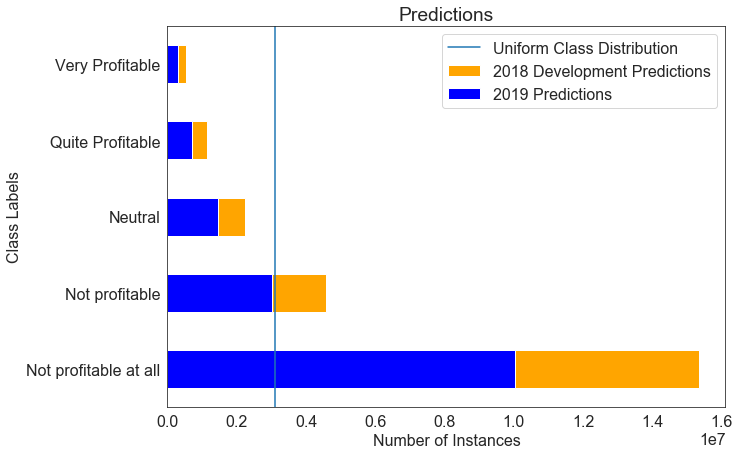

In [56]:
fig, ax = fig, ax = plt.subplots(1, 1, figsize=(10,7))

dev.predicted_rating.value_counts().plot.barh(label='2018 Development Predictions', ax=ax, color="orange")
df.predicted_rating.value_counts().plot.barh(label='2019 Predictions', ax=ax, color="blue")

plt.plot([3107766]*7, range(-1, 6), label='Uniform Class Distribution')

plt.title("Predictions")
plt.xlabel("Number of Instances")
plt.ylabel("Class Labels")
plt.yticks(range(5), ["Not profitable at all", "Not profitable", "Neutral", "Quite Profitable", "Very Profitable"])
plt.legend()

plt.show()

In [8]:
sf = gpd.read_file("./snow_data/taxi_zones.shp")
# Drop these columns since they are preserved in the zone_lookup.csv 
sf.drop(['OBJECTID','Shape_Leng','Shape_Area','zone','borough'],axis=1,inplace=True)
# Convert to long/lat 
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

In [9]:
sf.head()

,LocationID,geometry
0,1,"POLYGON ((-74.18445299999996 40.6949959999999,..."
1,2,(POLYGON ((-73.82337597260663 40.6389870471767...
2,3,POLYGON ((-73.84792614099985 40.87134223399991...
3,4,POLYGON ((-73.97177410965318 40.72582128133705...
4,5,POLYGON ((-74.17421738099989 40.56256808599989...


In [10]:
df = gpd.GeoDataFrame(pd.merge(df, sf, left_on='PULocationID', right_on='LocationID', how='left'))

In [11]:
df.head()

,PULocationID,hour,dow,predicted_rating,LocationID,geometry
0,217,3,5,0,217.0,POLYGON ((-73.95554165799997 40.70759344799991...
1,148,3,5,0,148.0,POLYGON ((-73.98447731699999 40.72023423899987...
2,113,4,5,0,113.0,POLYGON ((-73.99136388099988 40.72755978299991...
3,114,4,5,0,114.0,POLYGON ((-73.99257987399992 40.72420155499993...
4,223,20,1,0,223.0,"POLYGON ((-73.90649492923363 40.7901809903447,..."


In [23]:
# before 3pm split, hour col corresponds to count
before = df.loc[df.hour < 16].groupby(["PULocationID","predicted_rating"]).count()['hour'].reset_index()
before = gpd.GeoDataFrame(pd.merge(before, sf, left_on='PULocationID', right_on='LocationID', how='left'))
before['log_freq'] = np.log(before['hour'])

for i in range(5):
    geo = gpd.GeoDataFrame(before.loc[before['predicted_rating'] == i][['PULocationID','geometry']].dropna()).to_json()
    preds = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

    folium.Choropleth(
        geo_data=geo,
        name='choropleth',
        data=before,
        columns=['LocationID', 'log_freq'],
        key_on='properties.PULocationID',
        fill_color='OrRd',
        fill_opacity=0.9,
        line_opacity=0.5,
        legend_name=f'Predicted {i} Rating Zones 12am - 3pm'
    ).add_to(preds)

    preds.save(f'./pred_plots/2019before_label{str(i)}.html')

In [22]:
# after 4pm split, hour col corresponds to count
after = df.loc[df.hour >= 16].groupby(["PULocationID","predicted_rating"]).count()['hour'].reset_index()
after = gpd.GeoDataFrame(pd.merge(after, sf, left_on='PULocationID', right_on='LocationID', how='left'))
after['log_freq'] = np.log(after['hour'])

for i in range(5):
    geo = gpd.GeoDataFrame(after.loc[after['predicted_rating'] == i][['PULocationID','geometry']].dropna()).to_json()
    preds = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

    folium.Choropleth(
        geo_data=geo,
        name='choropleth',
        data=after,
        columns=['LocationID', 'log_freq'],
        key_on='properties.PULocationID',
        fill_color='OrRd',
        fill_opacity=0.9,
        line_opacity=0.5,
        legend_name=f'Predicted {i} Rating Zones 4pm - 12am'
    ).add_to(preds)

    preds.save(f'./pred_plots/2019after_label{str(i)}.html')

In [24]:
# daily combined
overall_agg = df.groupby(["PULocationID","predicted_rating"]).count()['hour'].reset_index()
overall_agg = gpd.GeoDataFrame(pd.merge(overall_agg, sf, left_on='PULocationID', right_on='LocationID', how='left'))
overall_agg['log_freq'] = np.log(overall_agg['hour'])

for i in range(5):
    geo = gpd.GeoDataFrame(overall_agg.loc[overall_agg['predicted_rating'] == i][['PULocationID','geometry']].dropna()).to_json()
    preds = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

    folium.Choropleth(
        geo_data=geo,
        name='choropleth',
        data=overall_agg,
        columns=['LocationID', 'log_freq'],
        key_on='properties.PULocationID',
        fill_color='OrRd',
        fill_opacity=0.9,
        line_opacity=0.5,
        legend_name=f'Predicted {i} Rating Zones'
    ).add_to(preds)

    preds.save(f'./pred_plots/overall{str(i)}.html')